# Web Analytics Metrics Importance

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from seaborn import distplot
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [25]:
#Loading DF
df = pd.read_csv('online_shoppers_intention.csv')
print(df.shape)
df.head()

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [26]:
#Dropping Nans
df = df.dropna()
print(df.shape)

(12316, 18)


In [27]:
df.describe().loc[['min','max']]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
min,0.0,-1.00,0.0,-1.000,0.0,-1.00000,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,1.0
max,27.0,3398.75,24.0,2549.375,705.0,63973.52223,0.2,0.2,361.763742,1.0,8.0,13.0,9.0,20.0


In [28]:
# Removing negative durations and those higher than the 99th quantile
quantile = df.ProductRelated_Duration.quantile(0.99)

df = df[(df['ProductRelated_Duration'] >= 0 )& (df['ProductRelated_Duration'] < quantile)] 
df.shape

(12159, 18)

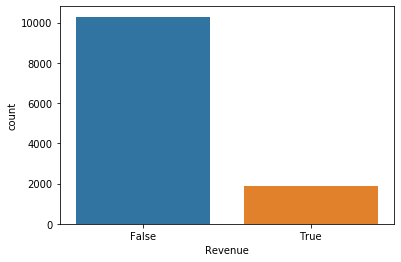

In [41]:
# As expected Revenue == True class is quite under-represented
sns.countplot(df["Revenue"])

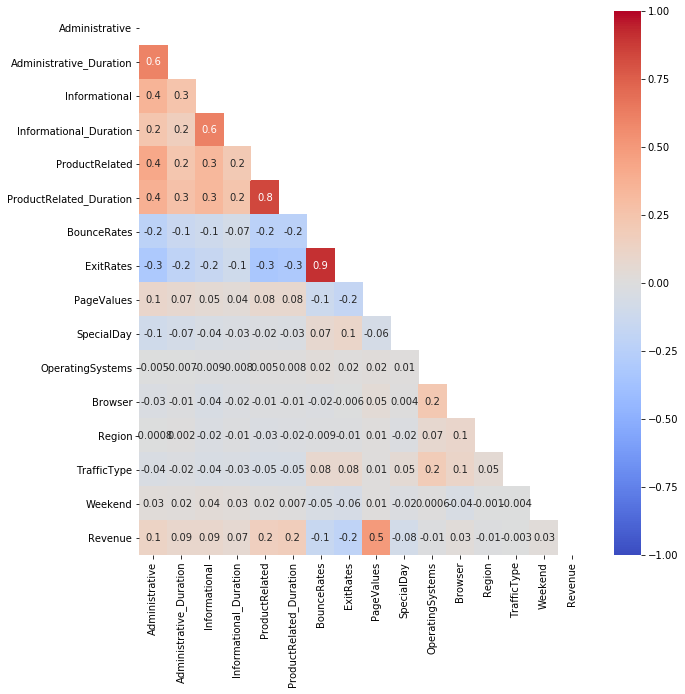

In [84]:
# Page Value seems quite important for Revenue
# BounceRates, ExitRatess, ProductRelated and ProductRelated_Duration as well to a lesser extent
mask = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, fmt='.1g', mask=mask, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [98]:
def plot_dist(col):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, dpi=100)
    sns.distplot(df.loc[df.Revenue==True, col], ax= axes[0] , color="green")
    sns.distplot(df.loc[df.Revenue==False, col], ax= axes[1], color="red")

<Figure size 432x288 with 0 Axes>

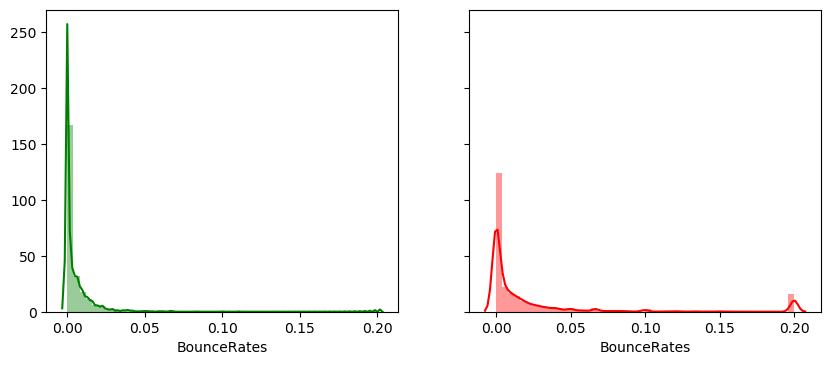

<Figure size 432x288 with 0 Axes>

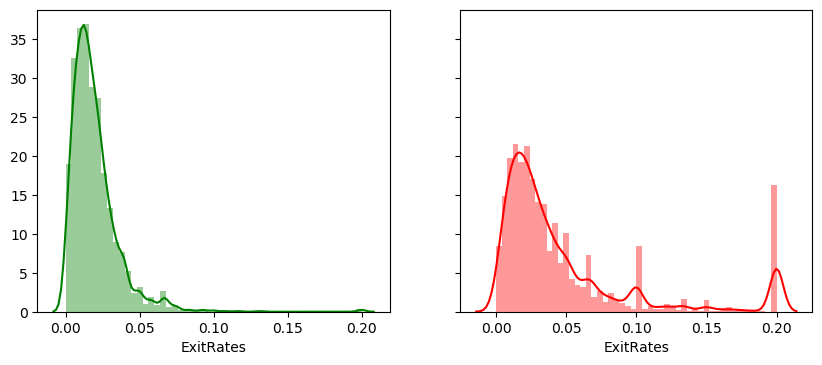

<Figure size 432x288 with 0 Axes>

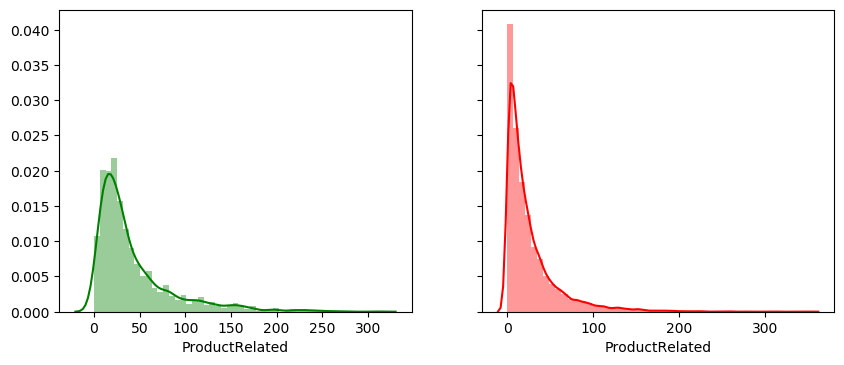

<Figure size 432x288 with 0 Axes>

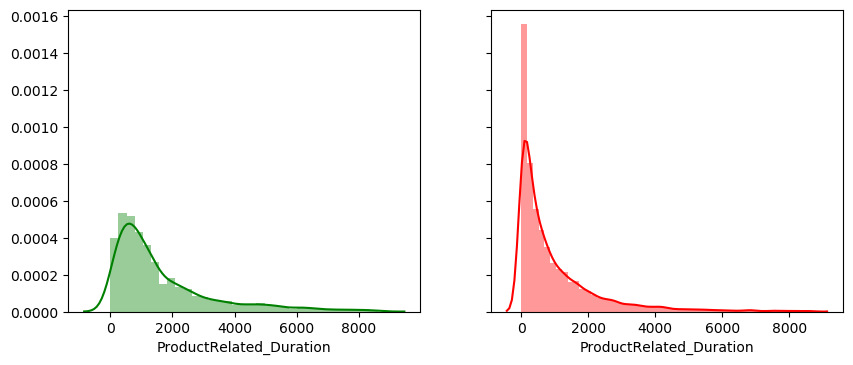

In [153]:
relevant_cols = ['BounceRates', 'ExitRates', 'ProductRelated', 'ProductRelated_Duration']

for i,col in enumerate(relevant_cols):
    plt.figure()
    plot_dist(col)

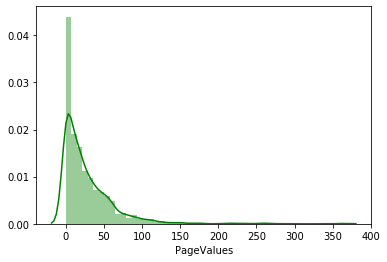

In [163]:
sns.distplot(df.loc[df.Revenue==True, 'PageValues'], color="green")

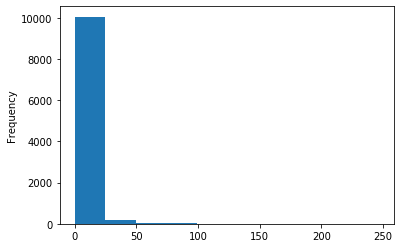

In [167]:
#For some reason Seaborn distplot does not work in this data
# Most of the pages of non-revenue-generating sessions have a very low value
# Although this is also true for the reneue-generating ones,
# the distribution is much more skewd to the right
df.loc[df.Revenue==False, 'PageValues'].plot(kind='hist')

In [100]:
#One-hot encoding of categorical values
data1 = pd.get_dummies(df)

In [107]:
x = data1.drop("Revenue", axis=1)
y = data1.Revenue

In [109]:
# Train, Test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 12)            

In [110]:
#Grid Search for best Parameters
param_grid = {'min_samples_leaf': [2, 3, 4, 5], 'n_estimators': [10,50,100, 200, 300, 1000]}

rf = RandomForestClassifier(random_state = 42)

#Cross validation on the RF model
grid_search = GridSearchCV(estimator = rf,          # Model
                           param_grid = param_grid, # Dictionary of parameters previously defined
                           cv =3)                   # 3-Fold cross validation

grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [112]:
# Classification report
#Obviously performs better in the False category
#It over estimates Trues
y_pred = grid_search.best_estimator_.predict(x_test)
print("Classification Report: \n{0}".format(classification_report(y_test, y_pred)))

Classification Report: 
              precision    recall  f1-score   support

       False       0.93      0.97      0.95      2073
        True       0.79      0.56      0.66       359

    accuracy                           0.91      2432
   macro avg       0.86      0.77      0.80      2432
weighted avg       0.91      0.91      0.91      2432



Text(0.5, 1.0, 'Feature Importance')

<Figure size 720x1440 with 0 Axes>

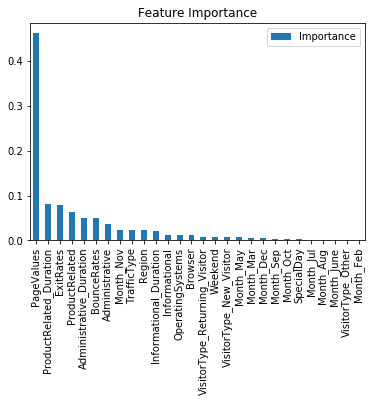

In [148]:
# Page Values is definitely the most important 
feature_importances = pd.DataFrame(grid_search.best_estimator_.feature_importances_,
                                   columns = ['Importance']).set_index(x.columns)

#Ploting Feature importance
plt.figure(figsize=(10, 20))
feature_importances.sort_values('Importance', ascending=False).plot(kind='bar')
plt.title("Feature Importance")